In [47]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import torch


In [2]:
base_path_train = "./MURA-v1.1/train"
print(os.path.abspath(base_path_train))

base_path_test = "./MURA-v1.1/test"
print(os.path.abspath(base_path_test))

c:\Users\jacob\OneDrive\Documents\GitHub\xray_classification_application\MURA-v1.1\train
c:\Users\jacob\OneDrive\Documents\GitHub\xray_classification_application\MURA-v1.1\test


In [51]:
def load_data(base_path):
    data = []

    if not os.path.exists(base_path):
        print(f"Error: Path does not exist -> {base_path}")
        return pd.DataFrame(data)
    for modality in os.listdir(base_path):
        modality_path = os.path.join(base_path, modality)
        if os.path.isdir(modality_path):
            for patient in os.listdir(modality_path):
                patient_path = os.path.join(modality_path, patient)
                if os.path.isdir(patient_path):
                    for study in os.listdir(patient_path):
                        study_path = os.path.join(patient_path, study)
                        if os.path.isdir(study_path):
                            for image in os.listdir(study_path):
                                image_path = os.path.join(study_path, image)
                                data.append({
                                    "bone_type": modality,
                                    "patient_id": patient,
                                    "classifier_type": study,
                                    "image_path": image_path
                                })
    return pd.DataFrame(data)

def restructure_mura(base_path, output_path):
    # Define train/valid directories
    for split in ["train", "valid"]:
        input_dir = os.path.join(base_path, split)
        output_dir = os.path.join(output_path, split)

        # Create positive and negative folders
        pos_dir = os.path.join(output_dir, "positive")
        neg_dir = os.path.join(output_dir, "negative")
        os.makedirs(pos_dir, exist_ok=True)
        os.makedirs(neg_dir, exist_ok=True)

        # Iterate through modality folders (e.g., XR_WRIST, XR_ELBOW, etc.)
        for modality in os.listdir(input_dir):
            modality_path = os.path.join(input_dir, modality)
            if os.path.isdir(modality_path):
                for patient in os.listdir(modality_path):
                    patient_path = os.path.join(modality_path, patient)
                    if os.path.isdir(patient_path):
                        for study in os.listdir(patient_path):
                            study_path = os.path.join(patient_path, study)
                            if os.path.isdir(study_path):
                                # Determine if study is positive or negative
                                if "positive" in study:
                                    target_folder = pos_dir
                                else:
                                    target_folder = neg_dir
                                
                                # Move all images into corresponding class folder
                                for image in os.listdir(study_path):
                                    image_path = os.path.join(study_path, image)
                                    new_image_path = os.path.join(target_folder, f"{patient}_{study}_{image}")
                                    
                                    if not os.path.exists(new_image_path):  # Avoid overwriting
                                        shutil.copy2(image_path, new_image_path)  

    print(f"MURA dataset successfully restructured in: {output_path}")

def load_image(img_path):

    #img_size = (256, 256)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    #resize and normalize 
    resized_image = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) 

    #resized_image = np.stack([resized_image]*3, axis=-1) 
    resized_image = resized_image 
    #image = np.array(resized_image).reshape(-1, img_size[0], img_size[1], 1)

    return resized_image



In [53]:
ouptut_path = './MURA-simple'
base_path = './MURA-v1.1'

restructure_mura(base_path, ouptut_path)

MURA dataset successfully restructured in: ./MURA-simple


In [4]:

xray_data_train = load_data(base_path_train)
print(xray_data_train.shape)
print(xray_data_train.head())

(36812, 4)
  bone_type    patient_id  classifier_type  \
0  XR_ELBOW  patient00011  study1_negative   
1  XR_ELBOW  patient00011  study1_negative   
2  XR_ELBOW  patient00011  study1_negative   
3  XR_ELBOW  patient00016  study1_positive   
4  XR_ELBOW  patient00016  study1_positive   

                                          image_path  
0  ./MURA-v1.1/train\XR_ELBOW\patient00011\study1...  
1  ./MURA-v1.1/train\XR_ELBOW\patient00011\study1...  
2  ./MURA-v1.1/train\XR_ELBOW\patient00011\study1...  
3  ./MURA-v1.1/train\XR_ELBOW\patient00016\study1...  
4  ./MURA-v1.1/train\XR_ELBOW\patient00016\study1...  


In [5]:
xray_data_red = xray_data_train.iloc[:50, :]
xray_data_red['image'] = xray_data_red['image_path'].apply(load_image)
xray_data_red.shape

C:\Users\jacob\AppData\Local\Temp\ipykernel_20384\2888555088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['image'] = xray_data_red['image_path'].apply(load_image)


(50, 5)

In [7]:
xray_data_train['images'] = xray_data_train['image_path'].apply(load_image)

error: OpenCV(4.6.0) C:\b\abs_d8ltn27ay8\croot\opencv-suite_1676452046667\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
xray_data_train.head()

Preprocess

In [6]:
def hist_eq_clahe(image):
    clahe = cv2.createCLAHE(clipLimit= 3, tileGridSize= (8,8))
    img = clahe.apply(image)

    return img 

def normalize_image(image):

    img = image / 255

    return img

def noise_reduce(image):

    img = cv2.GaussianBlur(image, (5,5), 0)
    img = cv2.convertScaleAbs(img)
    
    return img

def extract_edge(img):
    img_edge = cv2.Canny(img, 50, 100)
    return img_edge

def image_zoom(img):

    height, width = img.shape[:2]
    scale_x, scale_y = 5, 5
    new_width = int(width * scale_x)
    new_height = int(height * scale_y)
    cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return img

def zoom_center(img, zoom_factor=1.2):

    y_size = img.shape[0]
    x_size = img.shape[1]
    
    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor))
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))

    # first crop image then scale
    img_cropped = img[y1:y2,x1:x2]
    return cv2.resize(img_cropped, None, fx=zoom_factor, fy=zoom_factor)

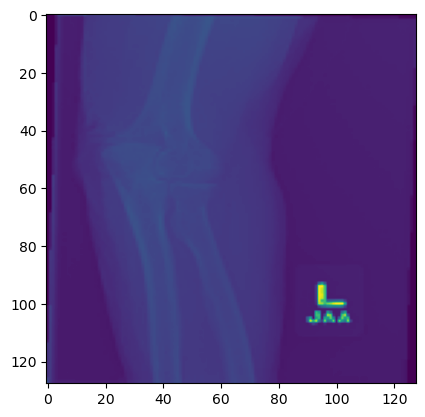

In [22]:
test_image = xray_data_red['image'][1]

plt.imshow(test_image)
plt.show()

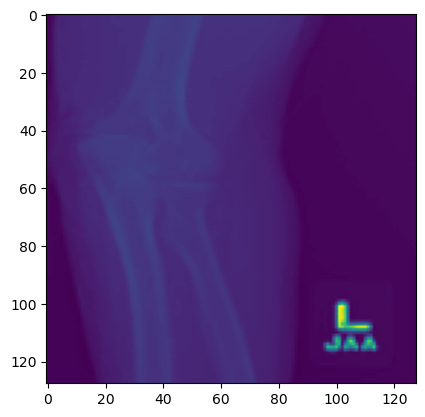

In [27]:
zoom_img = zoom_center(test_image)

plt.imshow(zoom_img)
plt.show()

In [ ]:
# clahe

#edge

#normalize

# CNN

In [56]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#from torchvision import datasets

In [57]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='./MURA-simple/train', transform=transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_channels, num_classes=2):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        #can add a ReLU fucntion here
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x



In [31]:
input_size = 16384
num_classes = 2 # normal/abnormal -> eventually switch to bone type
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [14]:
def one_hot_classifier_type(label):

    
    if label == 'study1_negative':
        new_label = 0
    else:
        new_label = 1
    
    return new_label

In [12]:

print(xray_data_red['classifier_type'].unique())

['study1_negative' 'study1_positive']


In [18]:
xray_data_red['labels'] = xray_data_red['classifier_type'].apply(one_hot_classifier_type)


C:\Users\jacob\AppData\Local\Temp\ipykernel_20384\3001846539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['labels'] = xray_data_red['classifier_type'].apply(one_hot_classifier_type)


In [19]:
xray_data_red.head()

,bone_type,patient_id,classifier_type,image_path,image,labels
0,XR_ELBOW,patient00011,study1_negative,./MURA-v1.1/train\XR_ELBOW\patient00011\study1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,XR_ELBOW,patient00011,study1_negative,./MURA-v1.1/train\XR_ELBOW\patient00011\study1...,"[[0, 0, 0, 25, 57, 51, 50, 52, 52, 54, 54, 53,...",0
2,XR_ELBOW,patient00011,study1_negative,./MURA-v1.1/train\XR_ELBOW\patient00011\study1...,"[[0, 0, 0, 0, 0, 0, 32, 28, 24, 24, 19, 16, 17...",0
3,XR_ELBOW,patient00016,study1_positive,./MURA-v1.1/train\XR_ELBOW\patient00016\study1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,XR_ELBOW,patient00016,study1_positive,./MURA-v1.1/train\XR_ELBOW\patient00016\study1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [32]:
model = CNN(num_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)